#### Prerequisites

- Basic familiarity with [Numpy](https://numpy.org/doc/stable/user/quickstart.html)
- Basic familiarity with [Pyplot](https://matplotlib.org/stable/tutorials/introductory/pyplot.html)

## Outline

- [Section 0](#section-0): NumPy Tips and Code Clarity
- [Section 1](#section-1): Intro to Linear Regression
- [Section 2](#section-2): Least Squared Loss and Maximum Likelihood
- [Section 3](#section-3): Ridge Regression
- [Section 4](#section-4): LASSO Regression



<a name="section-0"></a>

# Section 0: NumPy Tips and Code Clarity


There are multiple ways in NumPy to do each of the following basic operations:

- Matrix-matrix and matrix-vector product.
- Matrix-matrix and vector-vector element-wise product.
- vector-vector inner and outer products.

Avoid using general functions such as `np.dot` that handles most of these operations depending on the shapes of the input parameters.


Note: to check a function documentation, you can do that inside a Nootbook cell using `?<function_name>`.


In [1]:
import numpy as np
?np.dot

Docstring:
dot(a, b, out=None)

Dot product of two arrays. Specifically,

- If both `a` and `b` are 1-D arrays, it is inner product of vectors
  (without complex conjugation).

- If both `a` and `b` are 2-D arrays, it is matrix multiplication,
  but using :func:`matmul` or ``a @ b`` is preferred.

- If either `a` or `b` is 0-D (scalar), it is equivalent to
  :func:`multiply` and using ``numpy.multiply(a, b)`` or ``a * b`` is
  preferred.

- If `a` is an N-D array and `b` is a 1-D array, it is a sum product over
  the last axis of `a` and `b`.

- If `a` is an N-D array and `b` is an M-D array (where ``M>=2``), it is a
  sum product over the last axis of `a` and the second-to-last axis of
  `b`::

    dot(a, b)[i,j,k,m] = sum(a[i,j,:] * b[k,:,m])

It uses an optimized BLAS library when possible (see `numpy.linalg`).

Parameters
----------
a : array_like
    First argument.
b : array_like
    Second argument.
out : ndarray, optional
    Output argument. This must have the exact kind that 

In [2]:
# shape: (2, 2)
A = np.array([[1, 2], [3, 4]])

# shape: (2, 2)
B = np.array([[5, 6], [7, 8]])

# shape: (2, )
v1 =  np.array([5, 6])

# shape: (3, )
v2 = np.array([4, 5, 6])

# shape: (2, )
v3 = np.arange(8, 11)



In [3]:
result_matrix_matrix = np.dot(A, B)
# result_matrix_matrix = A @ B # Better


result_matrix_matrix

array([[19, 22],
       [43, 50]])

In [4]:

result_matrix_vector = np.dot(A, v1)
# result_matrix_vector = A @ v1 # Better
result_matrix_vector

array([17, 39])

In [5]:
result_inner_product = np.dot(v2, v3)
# result_inner_product = np.inner(v2, v3)
result_inner_product

137

**There are several issues in using `np.dot` in the previous cells**. It can be very confusing to read a code with `np.dot` as you are trying to understand what operation is actually intended. The reader is required first to read the documentation of `np.dot` and then probe the shape of the input parameters to interpret the expression.


To avoid confusion, consider the following practice:

- Use the explicit `@` operator for matrix-matrix and matrix-vector products.
- Use the explicit `*` operator for element-wise products or [broadcasted products](https://numpy.org/doc/stable/user/basics.broadcasting.html).
- Use the explicit `np.inner` function for inner product between 1-D vectors, same for `np.outer` function.

When you intend to work with an object as a 1-D vector, make sure you don't have excessive dimensions with size 1 of your array.

In [6]:
# shape: (1, 2)
v4 = np.array([[5, 6]])

# shape: (2, 1)
v5 = np.array([[5], [6]])

# This works due to broadcasting rules.
v4 * v5

array([[25, 30],
       [30, 36]])

In [7]:
f'v4.shape: {v4.shape}, v5.shape: {v5.shape},  v4.ndim: {v4.ndim},  v5.ndim: {v5.ndim}'

'v4.shape: (1, 2), v5.shape: (2, 1),  v4.ndim: 2,  v5.ndim: 2'

To fix this and deal with them as vectors:

In [8]:
v4 = v4.squeeze() # Now shape: (2, )
v5 = v5.squeeze() # Now shape: (2, )

f'v4.shape: {v4.shape}, v5.shape: {v5.shape},  v4.ndim: {v4.ndim},  v5.ndim: {v5.ndim}'


'v4.shape: (2,), v5.shape: (2,),  v4.ndim: 1,  v5.ndim: 1'

In [9]:
v4 * v5

array([25, 36])

General practice to improve readability and avoid unexpected behaviour:

- When possible use explicit expressions instead of general functions like `np.dot`.
- Ensure objects representing 1-D vectors have `ndim==1`. If you are writing a function that deals with vectors and parameters use `assert` statements to make sure the input parameters match what you expect.
- Never use the deprectated `np.matrix` class but always `np.array`.

# Linear Regression


<a name="section-1"></a>

##  Section 1: Intro to Linear regression

*Partly adapted from [Deisenroth, Faisal, Ong (2020)](https://mml-book.github.io/).*

The purpose of this notebook is to implement linear regression and explore some of its properties, relying mostly on the Python packages numpy and matplotlib.


In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Initial global configuration for matplotlib - this is useful to have high quality plots, avoiding to set these parameters for each plot
SMALL_SIZE = 12
MEDIUM_SIZE = 16
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

We first consider a linear regression problem of the form
$$
y = \boldsymbol x^T\boldsymbol\beta + \epsilon\,,\quad \epsilon \sim \mathcal N(0, \sigma^2)
$$
where $\boldsymbol x\in\mathbb{R}^{p}$ are inputs (i.e., a datapoint with $p$ features) and $y\in\mathbb{R}$ are noisy outcomes. The parameter vector $\boldsymbol\beta\in\mathbb{R}^{p}$ parametrizes the function.

We assume we have a training set $(\boldsymbol x^{(i)}, y^{(i)})$, $i=1,\ldots, N$. We summarize the sets of training inputs in:
$$
\boldsymbol X = %\underbrace{
\begin{bmatrix}
x_1^{(1)} & \cdots & x_p^{(1)}  \\
x_1^{(2)} & \cdots & x_p^{(2)}  \\
\vdots & \ddots & \vdots \\
x_1^{(N)} & \cdots & x_p^{(N)}  \\
\end{bmatrix}
%}
_{N\times p} \qquad
\boldsymbol y = %\underbrace{
\begin{bmatrix}
y^{(1)} \\ \vdots \\ y^{(N)}
\end{bmatrix} %}
_{N\times1}
$$
**Note that for now we do not include the intercept $\beta_0$.** We are interested in finding parameters $\boldsymbol\beta$ that map the inputs well to the ouputs according to the linear regression equation.

From the lecture, we know that the parameters $\boldsymbol\beta$ found by the following equation are optimal:
$$
\underset{\boldsymbol\beta}{\text{min}} \| \boldsymbol y - \boldsymbol X \boldsymbol\beta \|^2
%= \underset{\boldsymbol\beta}{\text{min}} \ \text{L}_{\text{LS}} (\boldsymbol\beta)
%where $\text{L}_{\text{LS}}$ is the (ordinary) least squares loss function.
$$
### Dataset generation
We will start with a simple training set, that we define by ourselves.

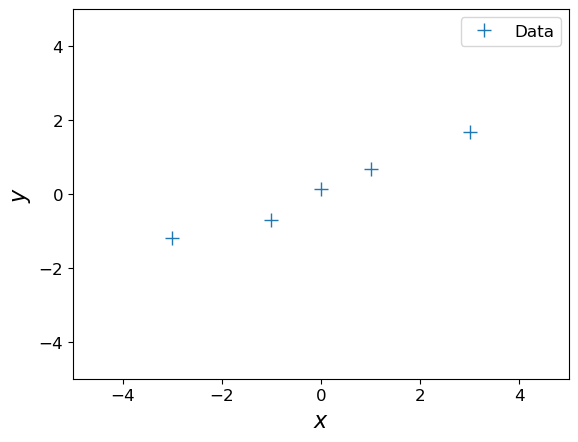

In [11]:
# Define training set
X = np.array([-3, -1, 0, 1, 3]).reshape(-1,1) # 5x1 vector, N=5, D=1
y = np.array([-1.2, -0.7, 0.14, 0.67, 1.67]).reshape(-1,1) # 5x1 vector

# Plot the training set

plt.figure()
plt.plot(X, y, '+', markersize=10, label='Data')
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.ylim(-5, 5)
plt.xlim(-5,5)
plt.legend()
plt.show()

<a name="section-2"></a>

## Section 2: Least squares loss and Maximum likelihood

The solution of the the (ordinary) least squares is
$$
\boldsymbol\beta^{*} = (\boldsymbol X^T\boldsymbol X)^{-1}\boldsymbol X^T\boldsymbol y \ \in\mathbb{R}^{p}\,,
$$


The same estimate of $\boldsymbol\beta$ we can be obtained by maximum liklihood estimation which gives statistical interpretation of linear regression. In maximum likelihood estimation, we can find the parameters $\boldsymbol\beta^{\mathrm{ML}}$ that maximize the likelihood
$$
p(\boldsymbol y | \boldsymbol X, \boldsymbol\beta) = \prod_{i=1}^N p(y^{(i)} | \boldsymbol x^{(i)}, \boldsymbol\beta)\,.
$$
From the lecture we know that the maximum likelihood estimator is the same obtained from least squares:
$$
\boldsymbol\beta^{\text{ML}} = \boldsymbol\beta^{*}= (\boldsymbol X^T\boldsymbol X)^{-1}\boldsymbol X^T\boldsymbol y \, .
$$

Let us compute $\boldsymbol\beta^{*}$  for the given training set.

In [15]:
## EDIT THIS FUNCTION
def max_lik_estimate(X, y):

    # X: N x p matrix of training inputs
    # y: N x 1 vector of training targets/observations
    # returns: maximum likelihood parameters (p x 1)

    # check X and y have the same length
    assert X.shape[0] == y.shape[0], "Input X and y have different lengths."

    N, p = X.shape
    beta_ml = np.linalg.inv(X.T @ X) @ X.T @ y ## <-- EDIT THIS LINE
    return beta_ml

In [16]:
# get maximum likelihood estimate
beta_ml = max_lik_estimate(X,y)

In [17]:
beta_ml

array([[0.499]])

We see that there is only one parameter fitted which is the gradient. This will limit the fitted line to go through the origin (0,0). Now, make a prediction using the maximum likelihood estimate that we just found.

In [43]:
## EDIT THIS FUNCTION
def predict_with_estimate(X_test, beta):

    # X_test: K x p matrix of test inputs
    # beta: p x 1 vector of parameters
    # returns: prediction of f(X_test); K x 1 vector

    # check X_test and beta have the same number of features
    assert X_test.shape[1] == beta.shape[0], "X_test and beta have incompatible dimensions."

    prediction = X_test.dot(beta) ## <-- EDIT THIS LINE

    return prediction

Let's see whether we got something useful:

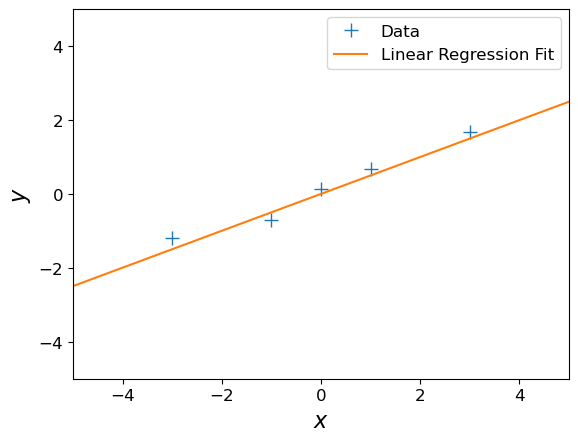

In [44]:
# define a test set
X_test = np.linspace(-5,5,100).reshape(-1,1) # 100 x 1 vector of test inputs

# predict the function values at the test points using the maximum likelihood estimator
ml_prediction = predict_with_estimate(X_test, beta_ml)

# plot
plt.figure()
plt.plot(X, y, '+', markersize=10, label='Data')
plt.plot(X_test, ml_prediction, label='Linear Regression Fit')
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.ylim(-5, 5)
plt.xlim(-5,5)
plt.legend()
plt.show()

#### Questions
1. Does the solution above look reasonable?
2. Play around with different values of $\beta$. How do the corresponding functions change?
3. Modify the training targets $\mathcal Y$ and re-run your computation. What changes?

Let us now look at a different training set, where we add 2.0 to every $y$-value, and compute the maximum likelihood estimate.

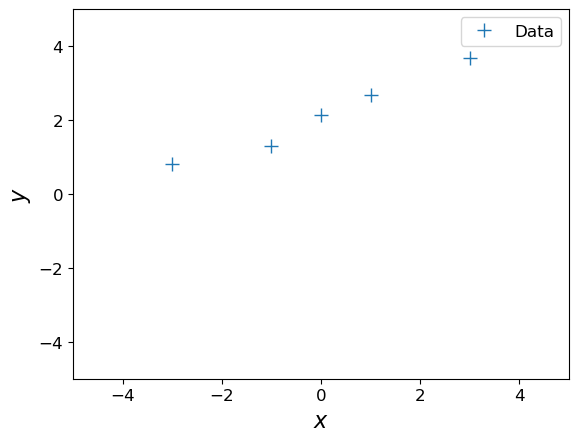

In [45]:
ynew = y + 2.0

plt.figure()
plt.plot(X, ynew, '+', markersize=10, label='Data')
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.ylim(-5, 5)
plt.xlim(-5,5)
plt.legend()

[[0.499]]


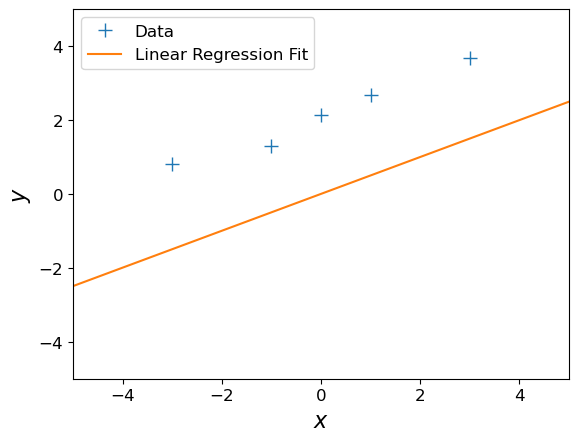

In [46]:
# get maximum likelihood estimate
beta_ml = max_lik_estimate(X, ynew)
print(beta_ml)

# define a test set
X_test = np.linspace(-5,5,100).reshape(-1,1) # 100 x 1 vector of test inputs

# predict the function values at the test points using the maximum likelihood estimator
ml_prediction = predict_with_estimate(X_test, beta_ml)

# plot
plt.figure()
plt.plot(X, ynew, '+', markersize=10, label='Data')
plt.plot(X_test, ml_prediction, label='Linear Regression Fit')
plt.ylim(-5, 5)
plt.xlim(-5,5)
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.legend()

#### Question:
1. This maximum likelihood estimate doesn't look too good: The orange line is too far away from the observations although we just shifted them by 2. Why is this the case?
2. How can we fix this problem?

Let us now define a linear regression model that is slightly more flexible:
$$
y = \beta_0 + \boldsymbol x^T \boldsymbol\beta_1 + \epsilon\,,\quad \epsilon\sim\mathcal N(0,\sigma^2)
$$

Here, we added an offset (also called bias or intercept) parameter $\beta_0$ to our original model.

#### Question:
1. What is the effect of this bias parameter, i.e., what additional flexibility does it offer?

If we now define the inputs to be the augmented vector $\boldsymbol x_{\text{aug}} = \begin{bmatrix}1\\\boldsymbol x\end{bmatrix}$, we can write the new linear regression model as
$$
y = \boldsymbol x_{\text{aug}}^T\boldsymbol\beta_{\text{aug}} + \epsilon\,,\quad \boldsymbol\beta_{\text{aug}} = \begin{bmatrix}
\beta_0\\
\boldsymbol\beta_1
\end{bmatrix}\,.
$$
So we obtain a more general model including an intercept term $\beta_0$. Hence we redefine $\boldsymbol X$ starting from $\boldsymbol x_{\text{aug}}$, obtaining in this the $\boldsymbol X$ used in the lecture notes:
$$
\boldsymbol X = %\underbrace{
\begin{bmatrix}
1 & x_1^{(1)} & \cdots & x_p^{(1)}  \\
1 & x_1^{(2)} & \cdots & x_p^{(2)}  \\
1 & \vdots & \ddots & \vdots \\
1 & x_1^{(N)} & \cdots & x_p^{(N)}  \\
\end{bmatrix}
%}
_{N\times (p+1)}
$$
and we will use this definition of $\boldsymbol X$ from now on.

In [47]:
N, p = X.shape
X_aug = np.hstack([np.ones((N,1)), X]) # augmented training inputs of size N x (p+1)
beta_aug = np.zeros((p+1, 1)) # new beta vector of size (p+1) x 1

Let us now compute the maximum likelihood estimator for this setting.

_Hint:_ Re-use code that you have already written.

In [48]:
## EDIT THIS FUNCTION
def max_lik_estimate_aug(X_aug, y):

    beta_aug_ml = np.linalg.inv(X_aug.T @ X_aug) @ X_aug.T @ y ## <-- EDIT THIS LINE

    return beta_aug_ml

In [49]:
beta_aug_ml = max_lik_estimate_aug(X_aug, ynew)

In [50]:
beta_aug_ml # offset + slope

array([[2.116],
       [0.499]])

We see that now there are two parameters fitted, the intercept and the gradient, which allowed more flexibilities. Now, we can make predictions again:

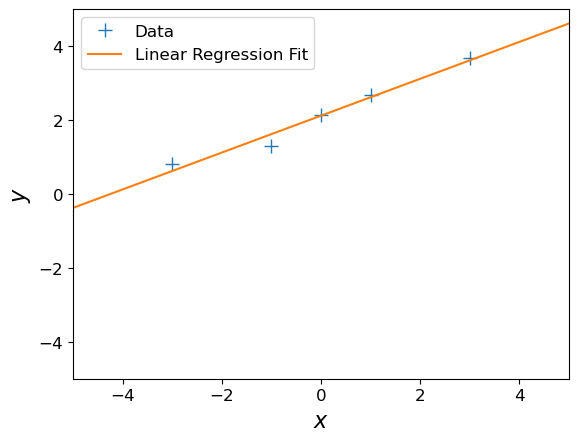

In [51]:
# define a test set (we also need to augment the test inputs with ones)
X_test_aug = np.hstack([np.ones((X_test.shape[0],1)), X_test]) # 100 x (p + 1) vector of test inputs

# predict the function values at the test points using the maximum likelihood estimator
ml_prediction = predict_with_estimate(X_test_aug, beta_aug_ml)

# plot
plt.figure()
plt.plot(X, ynew, '+', markersize=10, label='Data')
plt.plot(X_test, ml_prediction, label='Linear Regression Fit')
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.ylim(-5, 5)
plt.xlim(-5,5)
plt.legend()
plt.show()

It seems this has solved our problem!

#### Question:
1. Play around with the first parameter of $\boldsymbol\beta_{\text{aug}}$ and see how the fit of the function changes.
2. Play around with the second parameter of $\boldsymbol\beta_{\text{aug}}$ and see how the fit of the function changes.

<a name="section-3"></a>

## Section 3: Ridge regression

From our lectures, we know that ridge regression is an extension of linear regression with least squares loss function, including a (usually small) positive penalty term $\lambda$:
$$
\underset{\boldsymbol\beta}{\text{min}} \| \boldsymbol y - \boldsymbol X \boldsymbol\beta \|^2 + \lambda \| \boldsymbol\beta \|^2
$$
The solution is
$$
\boldsymbol\beta^{*}_{\text{ridge}} = (\boldsymbol X^T\boldsymbol X + \lambda I)^{-1}\boldsymbol X^T\boldsymbol y \, .
$$


This time, we will define a very small training set of only two observations to demonstrate the advantages of ridge regression over least squares linear regression.



In [52]:
X_train = np.array([0.5, 1]).reshape(-1,1)
y_train = np.array([0.5, 1])
X_test = np.array([0, 2]).reshape(-1,1)

Let's define function similar to the one for least squares, but taking one additional argument, our penalty term $\lambda$.

_Hint_: we apply the same augmentation as above with least squares, so the offset is accurately captured.

In [68]:
## EDIT THIS FUNCTION
def ridge_estimate(X, y, penalty):

    # X: N x p matrix of training inputs
    # y: N x 1 vector of training targets/observations
    # returns: maximum likelihood parameters ((p + 1) x 1)

    # check X and y have the same length
    assert X.shape[0] == y.shape[0], "Input X and y have different lengths."

    N, p = X.shape
    X_aug = np.hstack([np.ones((N,1)), X]) # augmented training inputs of size N x (p + 1)
    N_aug, p_aug = X_aug.shape
    I = np.identity(p_aug)
    I[0] = 0.0 # penalty excludes the bias term.
    beta_ridge = np.linalg.inv(X_aug.T @ X_aug + penalty * np.eye(2)) @ X_aug.T @ y ## <-- EDIT THIS LINE
    return beta_ridge

Now, we add a bit of Gaussian noise to our training set to mimic different realisations of the data sample and apply ridge regression. We should do it a couple of times (here 10 times) to obtain some statistics over the datasets.

[0.26990517 0.63311511]
[0.22850161 0.62338334]
[0.30048818 0.61775004]
[0.23103957 0.65100264]
[0.2806627  0.64904975]
[0.23372779 0.5954425 ]
[0.30450699 0.59430303]
[0.2012026  0.64853475]
[0.24613405 0.6020253 ]
[0.32830501 0.58637437]


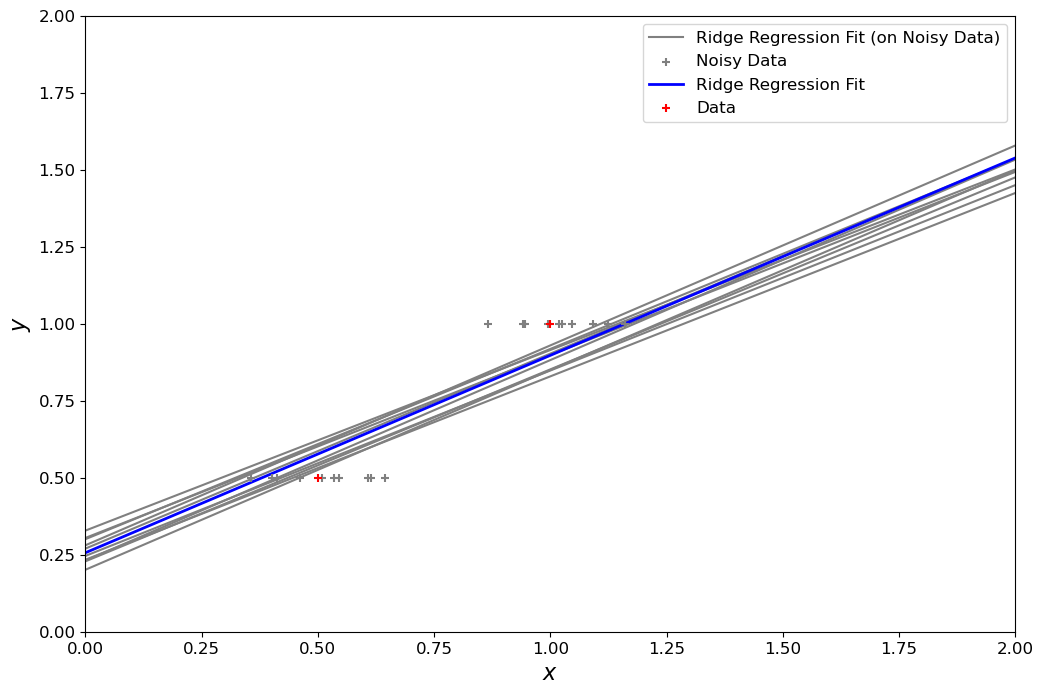

In [69]:
penalty_term = 0.1 # lambda fixed for the realisations
fig, ax = plt.subplots(figsize=(12, 8))
X_test_aug = np.hstack([np.ones((X_test.shape[0],1)), X_test])

# consider 10 noisy realisations
for i in range(10):
    # add Gaussian noise
    this_X = 0.1 * np.random.normal(size=(2, 1)) + X_train

    # fit ridge regression on noisy realisation
    beta_ridge = ridge_estimate(this_X, y_train, penalty=penalty_term)
    print(beta_ridge)
    ridge_prediction = predict_with_estimate(X_test_aug, beta_ridge)

    ax.plot(X_test, ridge_prediction, color='gray',
            label='Ridge Regression Fit (on Noisy Data)' if i == 0 else '')
    ax.scatter(this_X, y_train, c='gray', marker='+', zorder=10,
               label='Noisy Data' if i == 0 else '')

# fit ridge regression on original data
beta_ridge = ridge_estimate(X_train, y_train, penalty=penalty_term)
ridge_prediction_X = predict_with_estimate(X_test_aug, beta_ridge)

ax.plot(X_test, ridge_prediction_X, linewidth=2, color='blue', label='Ridge Regression Fit')
ax.scatter(X_train, y_train, c='red', marker='+', zorder=10, label='Data')
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.ylim(0, 2)
plt.xlim(0,2)
plt.legend()
plt.show()

Let's compare this to ordinary least squares:

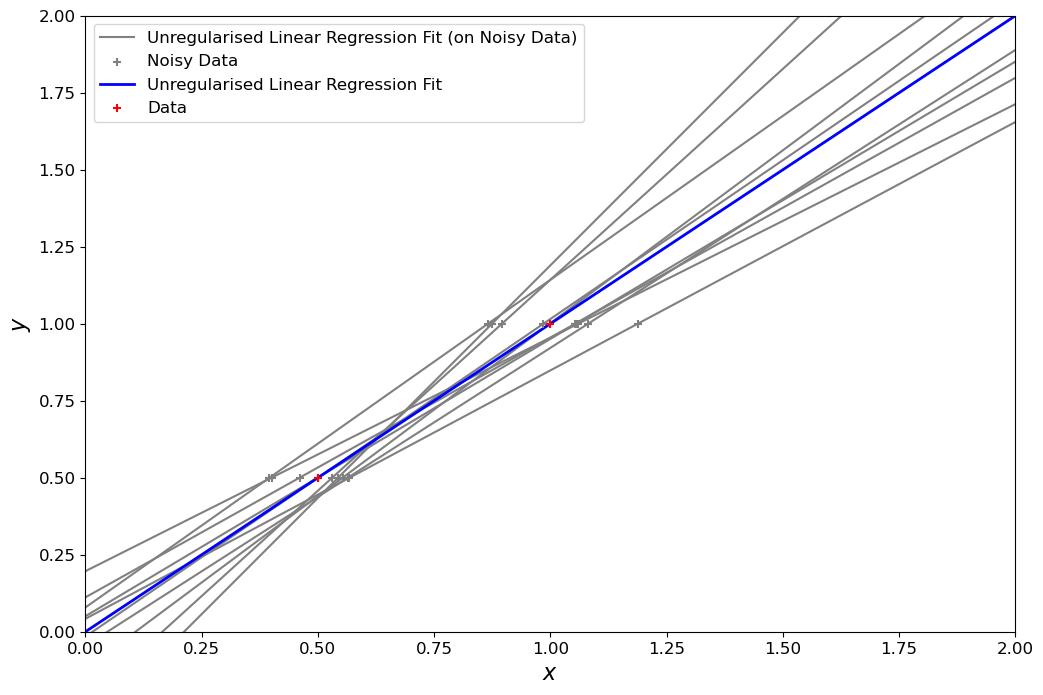

In [70]:
fig, ax = plt.subplots(figsize=(12, 8))
plt.xlim(0.0, 2)
plt.ylim(0.0, 2)

X_train_aug = np.hstack([np.ones((X_test.shape[0],1)), X_train])

X_test_aug = np.hstack([np.ones((X_test.shape[0],1)), X_test])

# consider 10 noisy realisations
for i in range(10):
    # add Gaussian noise
    this_X = 0.1 * np.random.normal(size=(2, 1)) + X_train
    N, p = this_X.shape
    this_X_aug = np.hstack([np.ones((N,1)), this_X])

    # fit ordinary LS regression on noisy realisation
    beta_aug_ml = max_lik_estimate_aug(this_X_aug, y_train)
    ml_prediction = predict_with_estimate(X_test_aug, beta_aug_ml)


    ax.plot(X_test, ml_prediction, color='gray',
            label='Unregularised Linear Regression Fit (on Noisy Data)' if i == 0 else '')
    ax.scatter(this_X, y_train, c='gray', marker='+', zorder=10,
               label = 'Noisy Data' if i == 0 else '')

# fit ordinary LS regression on original data
beta_aug_ml = max_lik_estimate_aug(X_train_aug, y_train)
ml_prediction_X = predict_with_estimate(X_test_aug, beta_aug_ml)

ax.plot(X_test, ml_prediction_X, linewidth=2, color='blue',
        label='Unregularised Linear Regression Fit')
ax.scatter(X_train, y_train, c='red', marker='+', zorder=10,
           label='Data')
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.ylim(0, 2)
plt.xlim(0,2)
plt.legend()
plt.show()

#### Questions
1. What differences between the two solutions above can you see?
2. **Optional**:
    - play around with different values of the penalty term $\lambda$. How do the corresponding functions change? Which values provide the most reasonable results?
    - Can you replicate your results using [`sklearn.linear_model.Ridge`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html)? [Note that this is only for comparison, sklearn is forbidden in the coursework].
    - Based on sklearn's documentation, can you see any differences in the algorithms that are implemented in sklearn?

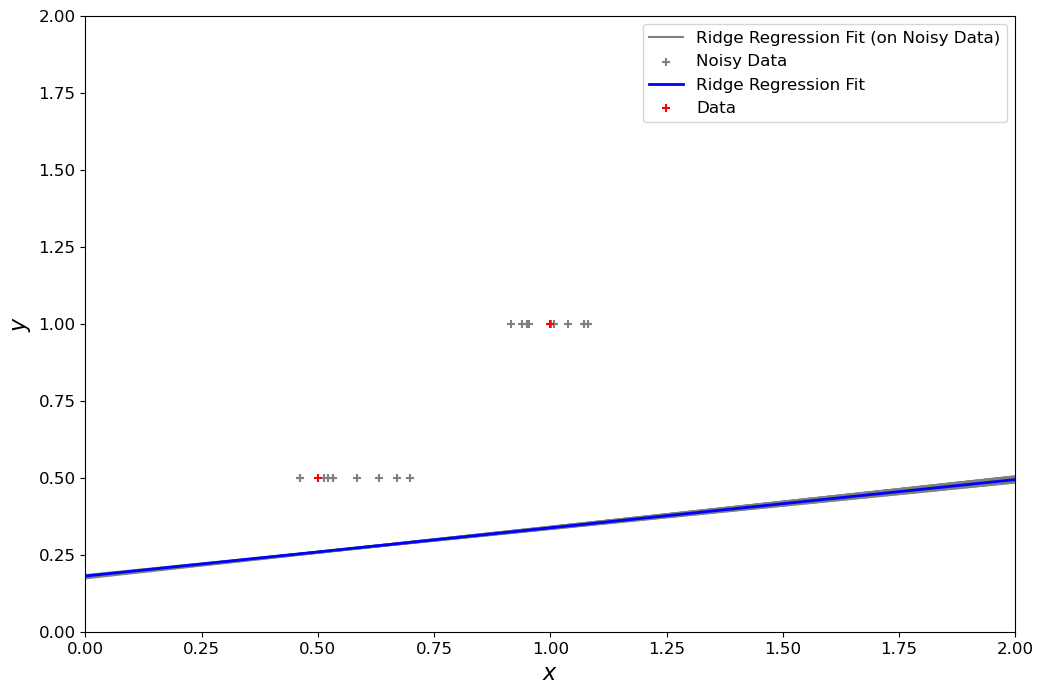

In [71]:
penalty_term = 5 # larger lambda here
fig, ax = plt.subplots(figsize=(12, 8))
X_test_aug = np.hstack([np.ones((X_test.shape[0],1)), X_test])

# consider 10 noisy realisations
for i in range(10):
    # add Gaussian noise
    this_X = 0.1 * np.random.normal(size=(2, 1)) + X_train

    # fit ridge regression on noisy realisation
    beta_ridge = ridge_estimate(this_X, y_train, penalty=penalty_term)
    ridge_prediction = predict_with_estimate(X_test_aug, beta_ridge)

    ax.plot(X_test, ridge_prediction, color='gray',
            label='Ridge Regression Fit (on Noisy Data)' if i == 0 else '')
    ax.scatter(this_X, y_train, c='gray', marker='+', zorder=10,
               label='Noisy Data' if i == 0 else '')

# fit ridge regression on original data
beta_ridge = ridge_estimate(X_train, y_train, penalty=penalty_term)
ridge_prediction_X = predict_with_estimate(X_test_aug, beta_ridge)

ax.plot(X_test, ridge_prediction_X, linewidth=2, color='blue', label='Ridge Regression Fit')
ax.scatter(X_train, y_train, c='red', marker='+', zorder=10, label='Data')
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.ylim(0, 2)
plt.xlim(0,2)
plt.legend()
plt.show()

<a name="section-4"></a>

## Section 4: LASSO regression

As opposed to the ridge regression which has a penalty term  $\| \boldsymbol\beta \|^2$, LASSO regression introduces $ \| \boldsymbol\beta \|_1 $, (also known as $L_1$ loss). $L_1$ loss is often preferred if we are interested in sparse parameters, i.e. few non-zero parameters. This is generally regarded as a feature selection task, and in high-dimensional problems it helps interpret the learned parameters and their relevance.
However, no closed-form solution exists for LASSO regression as in the standard and ridge regression, so we can use the iterative gradient-descent algorithm.


In LASSO regression the aim is to minimize the following loss:

$L_\text{LASSO}(\boldsymbol{\beta}) = || \boldsymbol{y} - \boldsymbol{X} \boldsymbol{\beta}||^2 + \lambda ||\boldsymbol{\beta}||_1$

Where $||\boldsymbol{\beta}||_1 = \sum_{i=1}^p |\beta_i|$


The absolute function $|.|$ adds nonsmoothness to the loss function, which can prevent the gradient-descent to converge properly to the optimal solution, and will keep bouncing around it instead. To solve this, we can use the Huber loss as an alternative to the $L_1$ loss; it combines the behaviour of $L_1$ loss to a quadratic function around the zero to obtain a `relaxed' form of the same optimisation.

Here one replaces $||\boldsymbol{\beta}||_1$ with the Huber Loss $\sum_{i=1}^p L_c(\beta_i)$, where $L_c(\beta_i)$ is defined as:

$L_c (\beta_i) =
\begin{cases}
 \frac{1}{2}{\beta^2_i}                   & \text{for } |\beta_i| \le c, \\
 c (|\beta_i| - \frac{1}{2}c), & \text{otherwise,}
\end{cases}
$

for $i=1,\ldots,p$.

The $c$ parameter in Huber determines the range around zero with $L_2$-like behaviour to ensure smoothness and, hence, better convergence.

The piecewise smooth function $L_c (\beta_i)$ has the gradient:

$\frac{dL_c (\beta_i)}{d\beta_i} =
  \begin{cases}
 \beta_i                   & \text{for } |\beta_i| \le c, \\
 c\, \text{sign}(\beta_i) , & \text{otherwise,}
\end{cases}
$

for $i=1,\ldots,p$.

Now we can minimise the following relaxed function by gradient descent:

$
\begin{align} L_\text{LASSO-Huber}(\boldsymbol{\beta})
&= || \boldsymbol{y} - \boldsymbol{X} \boldsymbol{\beta}||^2 + \lambda \sum_{i=1}^p L_c(\beta_i) \\
&= (\boldsymbol{y} - \boldsymbol{X}\boldsymbol{\beta})^T(\boldsymbol{y} - \boldsymbol{X}\boldsymbol{\beta})  + \lambda \sum_{i=1}^p L_c(\beta_i) \\
&= \left(\boldsymbol{y}^T\boldsymbol{y} - \boldsymbol{y}^T\boldsymbol{X}\boldsymbol{\beta} - \boldsymbol{\beta}^T\boldsymbol{X}^T  \boldsymbol{y} + \boldsymbol{\beta}^T\boldsymbol{X}^T\boldsymbol{X}\boldsymbol{\beta}\right) + \lambda \sum_{i=1}^p L_c(\beta_i)
\end{align}
$

Which has the gradient:

\begin{align}
\nabla_{\boldsymbol{\beta}} L_{\text{LASSO-Huber}}
&= 2\left(\boldsymbol{X}^T \boldsymbol{X} \boldsymbol{\beta}
- \boldsymbol{X}^T \boldsymbol{y}\right)
+ \lambda \nabla_{\boldsymbol{\beta}} L_c(\boldsymbol{\beta})
\end{align}


Optimisation method:
- **Initialise** $\boldsymbol{\beta}$ with zeros.
- Use Gradient-descent for tuning $\boldsymbol{\beta}$


Implementated in Python as:

In [72]:
# huber loss
def huber(beta, c = 1e-6):
    return np.where(np.abs(beta) < c, (beta**2)/2.,c * (np.abs(beta) - c/2))

# gradient of huber loss
def grad_huber(beta, c = 1e-6):
    g = np.empty_like(beta)
    return  np.where(np.abs(beta) < c, beta, c * np.sign(beta))

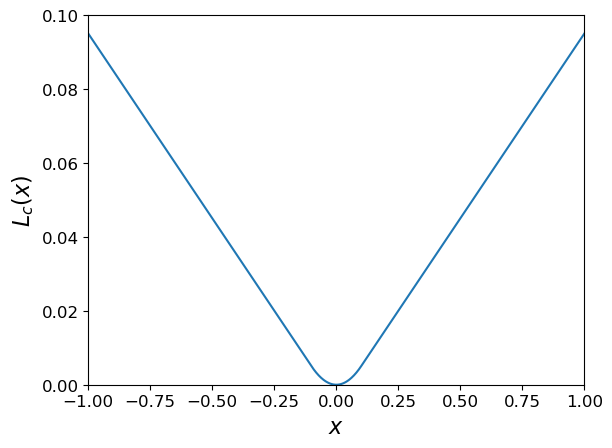

In [73]:
# range to plot over
a = np.linspace(-1, 1, 1000)
plt.plot(a, huber(a, c=0.1))
plt.xlabel("$x$")
plt.ylabel("$L_{c}(x)$")
plt.ylim(0, 0.1)
plt.xlim(-1, 1)
plt.show()

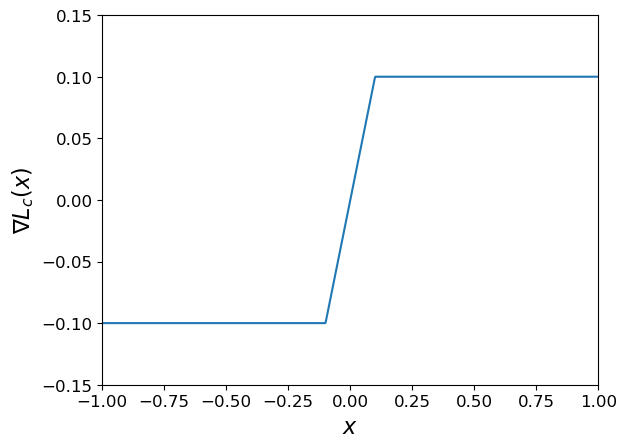

In [74]:
# range to plot over
a = np.linspace(-1, 1, 1000)
plt.plot(a, grad_huber(a, c=0.1))
plt.xlabel("$x$")
plt.ylabel(r'$ \nabla L_{c}(x)$') # The r in r'$ \nabla L_{LASSO-Huber}(x)$' is a prefix indicating a raw string. Read if interested: https://www.digitalocean.com/community/tutorials/python-raw-string
plt.ylim(-0.15, 0.15)
plt.xlim(-1, 1)
plt.show()

Question: Try different $c$ values and observe the difference

### Optimisation with gradient-descent

We next implement gradient-descent to solve the optimisation for the LASSO model. Recall from the lecture notes that gradient descent is an algorithm that follows iteratively the direction of $-\nabla_{\boldsymbol \beta}L(\boldsymbol \beta)$, where $L(\boldsymbol \beta)$ is the loss to be minimsed (here $L_\text{LASSO-Huber}(\boldsymbol{\beta})$). At the  iteration $t+1$ the parameters are updated according to:
$$
\boldsymbol \beta_{t+1} = \boldsymbol \beta_t - \eta_t \nabla_{\boldsymbol \beta} L(\boldsymbol \beta_t)
$$
where $\eta_t$ is the step size.

In [84]:
def minimize_ls_huber(X, y, lambd, n_iters = 10000, step_size=5e-5, c_huber=1e-4):
    """
    This function estimates the regression parameters with the relaxed version
    of LASSO regression using the gradient-descent algorithm to find the optimal
    solution.
    Args:
    X (np.array): The augmented data matrix with shape (N, p + 1).
    y (np.array): The response column with shape (N, 1).
    lambd (float): The multiplier of the relaxed L1 term.
    n_iters (int): Number of gradient descent iterations.
    step_size (float): The step size in the updating step.
    """

    # check X and y have the same length
    assert X.shape[0] == y.shape[0], "Input X and y have different lengths."

    N, p = X.shape
    # Precomputed products to avoid redundant computations.
    XX = X.T @ X
    Xy = X.T @ y
    # Initialize beta params with zeros
    beta = np.zeros(p)

    for i in range(n_iters):
        # Compute the gradient of the relaxed LASSO, Huber.
        grad_c = grad_huber(beta, c=c_huber)

        # Intercept term is not involved in the regularisation.
        grad_c[0] = 0 ## <-- EDIT THIS LINE

        # Compute the gradient of the regularised loss.
        grad =  2 * (XX @ beta - Xy) + lambd * grad_c ## <-- EDIT THIS LINE

        # Update beta
        beta -= step_size * grad ## <-- EDIT THIS LINE

    return beta

To study the feature selection capability of LASSO, we generate a 3 dimensional synthetic data set $X$ where the second dimension does not contribute significantly to the target $y$.

In [85]:
np.random.seed(42)

# Generate random data with three features
X1 = np.random.rand(100)
X2 = np.random.rand(100)  # Insignificant feature (with small beta below)
X3 = np.random.rand(100)
true_beta = np.array([8, 0.5, 9])  # Weights for features
y = X1 * true_beta[0] + X2 * true_beta[1] + X3 * true_beta[2] + np.random.randn(100)

We can compare the ground truth coefficients used to create the synthetic data set to the optimal LASSO coefficients. We observe that the insignificant second feature has an optimal LASSO coefficent close to zero, and this illustrates that LASSO only selects the first and third feature as significant.

In [86]:
# Add bias term
X_aug = np.stack((np.ones(100), X1, X2, X3), axis=1)

# Run LASSO regression
beta_lasso = minimize_ls_huber(X_aug, y, 5e3, n_iters=15000,
                                step_size=1e-5,
                                c_huber=1e-5)

# Print the result
print("LASSO Regression Coefficients:")
print("Beta (Intercept):", beta_lasso[0])
print("Beta 1:", beta_lasso[1])
print("Beta 2:", beta_lasso[2])
print("Beta 3:", beta_lasso[3])

LASSO Regression Coefficients:
Beta (Intercept): 1.1480830484374416
Beta 1: 7.395870128854849
Beta 2: -0.03532017586256803
Beta 3: 8.10465216874765


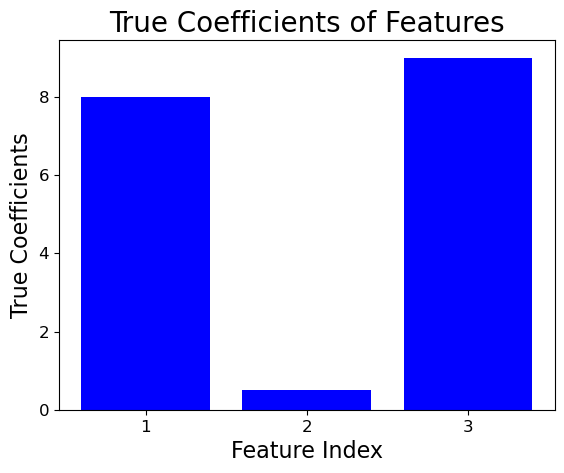

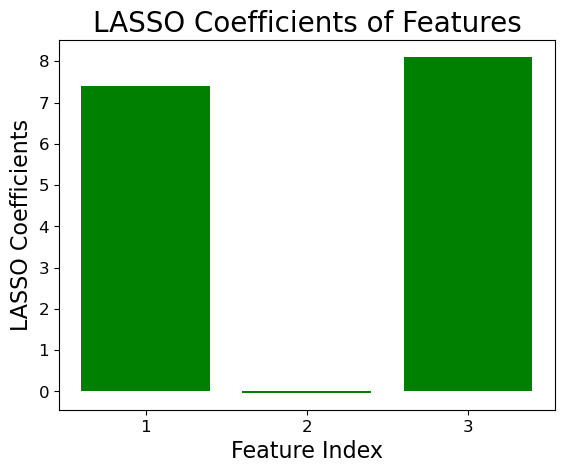

In [87]:
import matplotlib.pyplot as plt

for beta, label in ((true_beta, 'True'), (beta_lasso[1:4], 'LASSO')):
    plt.bar([1,2,3], beta, color='blue' if label == 'True' else 'green')
    plt.xlabel('Feature Index')
    plt.xticks([1,2,3])
    plt.ylabel(f'{label} Coefficients')
    plt.title(f'{label} Coefficients of Features')
    plt.show()

#### Questions

1. Try adding more **insignificant** variables and repeat the experiments. Do you still get the expected sparse solution? If not, what hyperparameters might need a re-tune?

2. Can you observe a clear pattern in how coefficients change as the penalty term $\lambda$ varies? Can you create a plot that shows the trajectory of each coefficient as $\lambda$ changes?

3. **Optional**:
    - Can you replicate your results using [`sklearn.linear_model.Lasso`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html#sklearn.linear_model.Lasso)?
    - Based on sklearn's documentation, can you see any differences in the algorithms that are implemented in sklearn?



#### Answers


We repeat the experiment on a five dimensional dataset $X$ where the second and fifth dimensions contribute insignicantly to the target $y$.

In [88]:
np.random.seed(0)

# Generate random data with five features
X1 = np.random.rand(100)
X2 = np.random.rand(100)  # Insignificant feature (with small beta below)
X3 = np.random.rand(100)
X4 = np.random.rand(100)
X5 = np.random.rand(100) # Insignificant feature (with small beta below)

true_beta = np.array([8, 0.5, 9, 4, 0.01])  # Weights for features

y = X1 * true_beta[0] + X2 * true_beta[1] + X3 * true_beta[2] +  X4 * true_beta[3] +  X5 * true_beta[4] + np.random.randn(100)
# Add bias term
X_aug = np.stack((np.ones(100), X1, X2, X3, X4, X5), axis=1)

We can now study the effect of the penality term $\lambda$ on the LASSO coefficients.

In [89]:
def lasso_coefficient_trajectories(lambdas, X_aug, y):
    """Computes the trajectories of the LASSO coeffiencts for a list of lambdas.
    """
    # initialise trajectories
    coeff_trajectories = []
    for lam in lambdas:
        # Run LASSO regression
        beta_lasso = minimize_ls_huber(X_aug, y, lambd=lam, n_iters=15000,
                                        step_size=1e-5,
                                        c_huber=1e-5)
        coeff_trajectories.append(beta_lasso[1:6])
    return np.vstack(coeff_trajectories)

In [90]:
# define range for lambdas
lambdas = np.logspace(-5, 5, 40) * 200

# compute the trajectories of LASSO coefficients
coeffs = lasso_coefficient_trajectories(lambdas, X_aug, y)

Plotting the trajectories of the LASSO coefficients for the 5 different features below shows us that the insiginifcant features 2 and 5 are always assigned LASSO coefficients close to zero. Only when the regularization is very strong, i.e., for large values of $\lambda$, all coefficients are pushed towards zero.

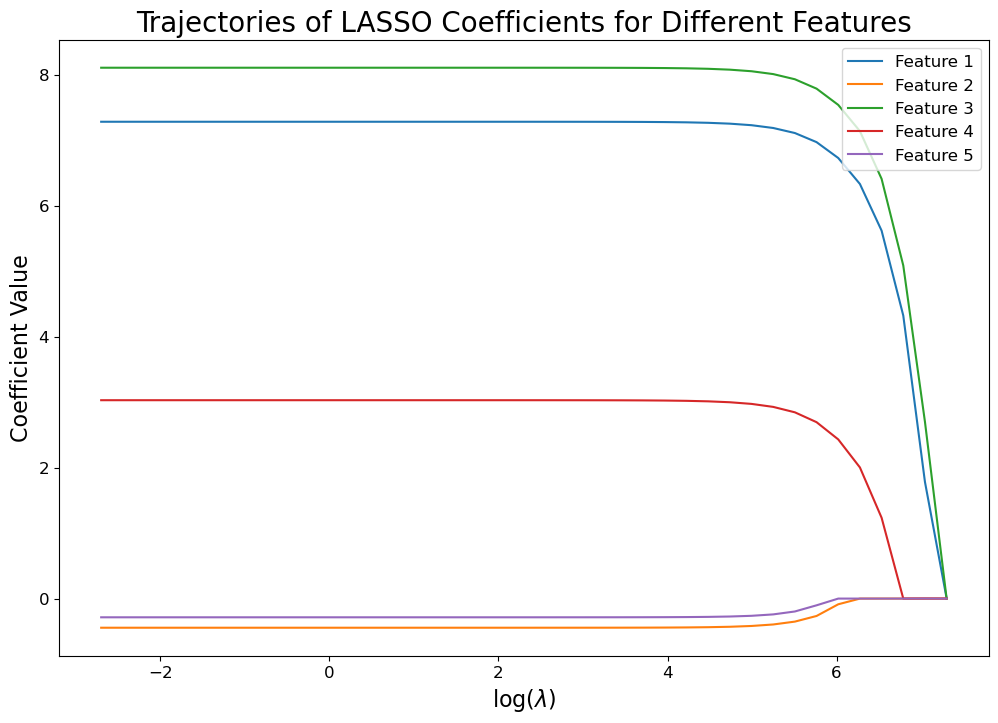

In [91]:
# plot the trajectores of LASSO coefficients using log-scale
plt.figure(figsize=(12, 8))
for i in range(coeffs.shape[1]):
    plt.plot(np.log10(lambdas), coeffs[:, i], label=f'Feature {i + 1}')

plt.xlabel('log($\lambda$)')
plt.ylabel('Coefficient Value')
plt.title('Trajectories of LASSO Coefficients for Different Features')
plt.legend()
plt.show()